In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/luke/miniconda3/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
ndata = 1000

X = 1
dx = 0.001
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
T = 2
dt = 0.0001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

In [3]:
# Dataset Generation. Uncomment these lines if you want to generate your own dataset

# def solveThetaFunction(x, gamma):
#     theta = np.zeros(nx)
#     for idx, val in enumerate(x):
#         theta[idx] = 5*math.cos(gamma*math.acos(val))
#     return theta
        
# def solveKernelFunction(theta):
#     kappa = np.zeros(nx)
#     for i in range(0, nx):
#         kernelIntegral = 0
#         for j in range(0, i):
#             kernelIntegral += (kappa[i-j]*theta[j])*dx
#         kappa[i] = kernelIntegral  - theta[i]
#     return np.flip(kappa)
        
# x = []
# y = [] 
# gammaArr= []
# for i in range(ndata):
#     gamma = np.random.uniform(2, 10)
#     theta = solveThetaFunction(spatial, gamma)
#     kappa = solveKernelFunction(theta)
#     gammaArr.append(gamma)
#     x.append(theta)
#     y.append(kappa)
    
# x= np.array(x, dtype=np.float32)
# y= np.array(y, dtype=np.float32)
# np.savetxt("x.dat", x)
# np.savetxt("y.dat", y)
# np.savetxt("gamma.dat", gammaArr)
# x = x.reshape(x.shape[0], x.shape[1], 1)
# y = y.reshape(y.shape[0], y.shape[1], 1)

In [4]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes=12
width=32

X = 1
dx = 0.001
nx = int(round(X/dx))
grid = np.linspace(0, X, nx, dtype=np.float32).reshape(nx, 1)
grid = torch.from_numpy(np.array(grid)).cuda()

In [5]:
# Create train/test splits
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)
gammaArr = np.loadtxt("gamma.dat", dtype=np.float32)
y = y.reshape(y.shape[0], y.shape[1])
x = x.reshape(x.shape[0], x.shape[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [6]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [7]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 1
m = 1000
model = dde.nn.DeepONetCartesianProd([m, 512, 256], [dim_x, 128, 256], "relu", "Glorot normal").cuda()
print(count_params(model))

677121


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [9]:
loss = LpLoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))        
        
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model((x, grid))
            out = out.reshape((out.shape[0], out.shape[1]))
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.39613302994985133 1.0068866584036085 0.7631757497787476
50 0.04223204799927771 0.06428775820467207 0.05588321387767792
100 0.041976460022851825 0.04089665375649929 0.0375862080603838
150 0.04216234793420881 0.019420782683624162 0.016008165664970875
200 0.044522887910716236 0.012886070687737729 0.012617758847773075
250 0.04589147388469428 0.00825507501140237 0.007899712864309549
300 0.04040307202376425 0.006575955533319049 0.00691855801269412
350 0.04123380407691002 0.0060642672340489095 0.006373027991503477
400 0.04095468309242278 0.005561518669128418 0.006008550804108381
450 0.041190994903445244 0.005398673005402088 0.005900911800563335


Avg Epoch Time: 0.043529670367250216
Final Testing Loss: 0.005903484392911195
Final Training Loss: 0.00531153529882431


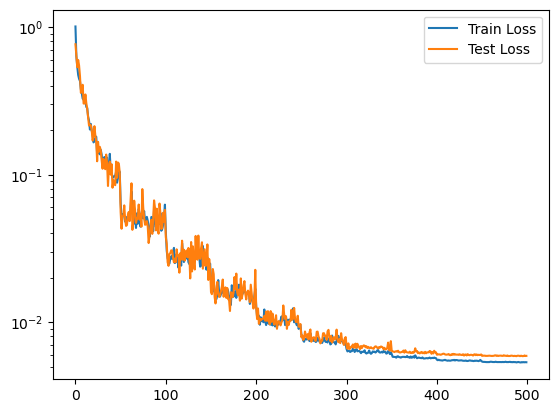

In [10]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        trainLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        testLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss/len(testData))
print("Final Training Loss:", trainLoss/len(trainData))

In [11]:
def solveKernelFunction(theta):
    kappa = np.zeros(nx)
    for i in range(0, nx):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*theta[j])*dx
        kappa[i] = kernelIntegral  - theta[i]
    return np.flip(kappa)
        
def solveControl(u, kernel):
    res = 0
    for i in range(nx):
        res += kernel[i]*u[i]
    return res*dx

# Solves the PDE for a single instance of theta and kappa. Returns solution and control values
def solvePDE(theta, kappa, init_condition, x, t):
    u = np.zeros((len(t), len(x)))
    U = np.zeros(len(t))

    # Set intial condition
    for i in range(len(x)):
        u[0][i] = init_condition[i]
    print("Solving PDE... Timesteps Needed:", len(t))
    for i in range(1, len(t)):
        if i%int(len(t)/10) == 0:
            print("Completed:", i, "/", len(t))
        u[i][-1] = solveControl(u[i-1], kappa)
        U[i] = u[i][-1]
        for j in range(0, nx-1):
            u[i][j] = u[i-1][j] + dt*((u[i-1][j+1] - u[i-1][j])/dx + theta[j]*u[i-1][0])
    return u, U


def solveOpenLoop(theta, kappa, init_condition, x, t):
    u = np.zeros((len(t), len(x)))

    # Set intial condition
    for i in range(len(x)):
        u[0][i] = init_condition[i]

    for i in range(1, len(t)):
        u[i][-1] = 0
        for j in range(0, nx-1):
            u[i][j] = u[i-1][j] + dt*((u[i-1][j+1] - u[i-1][j])/dx + theta[j]*u[i-1][0])
    
    return u

def getGamma(theta):
    for val in gammaArr:
        if np.isclose(5*math.cos(val*math.acos(0.001)), theta[0]):
            return val
    return -1

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt)
    for i in range(nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i] = error
    return pdeError

In [12]:
# Get 20 instances of test data. 
for x, y in testData:
    xinst, yinst = x.cuda(), y.cuda()
    out = model((xinst, grid))
print(out.shape)
# Get instances
ndata = 2
yhat = []
x = []
y = []
    
# Handpick
# Build beta = 3 example
def solveThetaFunction(x, gamma):
    theta = np.zeros(nx)
    for idx, val in enumerate(x):
        theta[idx] = 5*math.cos(gamma*math.acos(val))
    return theta
        
def solveKernelFunction(theta):
    kappa = np.zeros(nx)
    for i in range(0, nx):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*theta[j])*dx
        kappa[i] = kernelIntegral  - theta[i]
    return np.flip(kappa)
        
# Decide to load model pretrained or use model. To use pretrained uncomment this line. To use trained, 
#comment this line
#model.load_state_dict(torch.load('betaToKTorchModel'))
    
gamma = 3
theta = np.array(solveThetaFunction(spatial, gamma), dtype=np.float32)
kappa = np.array(solveKernelFunction(theta), dtype=np.float32)
theta = torch.from_numpy(theta.copy().reshape(1, theta.shape[0])).cuda()
kappa = torch.from_numpy(kappa.copy().reshape(1, kappa.shape[0])).cuda()
res = model((theta, grid))
yhat.append(res.cpu().detach().numpy().flatten())
x.append(theta.cpu().detach().numpy().flatten())
y.append(kappa.cpu().detach().numpy().flatten())

inst = 13
yhat.append(out[inst].cpu().detach().numpy().flatten())
x.append(xinst[inst].cpu().detach().numpy().flatten())
y.append(yinst[inst].cpu().detach().numpy().flatten())  
print("Gamma for Inst 2:", getGamma(x[-1]))

topenloop = np.linspace(0, 5, int(nt*2.5))

# Showcase PDE Difference
init_cond = np.zeros(1001)
init_cond.fill(10)
#topenloop = np.linspace(0, 5, 5000)
uarr = []
uhatarr = []
uopenarr = []
for i in range(ndata):
    if i == 1:
        init_cond = np.zeros(1001)
        init_cond.fill(5)
    u, U = solvePDE(x[i], y[i], init_cond, spatial, temporal)
    uhat, Uhat = solvePDE(x[i], yhat[i], init_cond, spatial, temporal)
    uarr.append(u)
    uhatarr.append(uhat)
    uopen = solveOpenLoop(x[i], y[i], init_cond, spatial, topenloop)
    uopenarr.append(uopen)


torch.Size([20, 1000])
Gamma for Inst 2: 7.3486667
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed

In [13]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

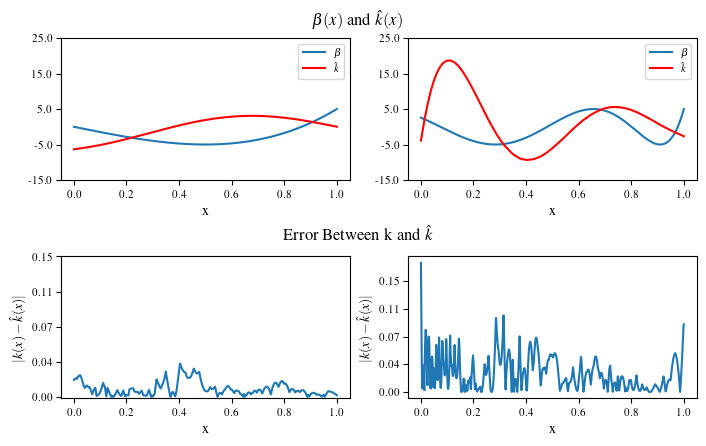

In [15]:
fig = plt.figure(figsize=set_size(516, 0.99, (2, 2)))
#plt.subplots_adjust(left=0.01, bottom=0, right=0.96, top=1, wspace=0.05, hspace=0)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"$\beta(x)$ and $\hat{k}(x)$")
subfig.subplots_adjust(left=0.08, bottom=0.2, right=0.98, top=0.85, wspace=0.2, hspace=0.2)
ax = subfig.subplots(nrows=1, ncols=2)

yticks = np.linspace(-15, 25, 5)

# Flip because kernel is constructed backwards for ease of use in control (ie 1-y)
ax[1].plot(spatial, x[1], label=r"$\beta$")   
ax[1].plot(spatial,yhat[1], label=r"$\hat{k}$", color="red")
ax[1].legend()
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[1].set_xlabel("x")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].plot(spatial, x[0], label=r"$\beta$")   
ax[0].plot(spatial, yhat[0], label=r"$\hat{k}$", color="red")
ax[0].legend()
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("x")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].set_yticks(yticks)
ax[1].set_yticks(yticks)


yticks = np.linspace(0, 0.15, 5)
    
subfig = subfigs[1]
subfig.subplots_adjust(left=0.08, bottom=0.2, right=0.98, top=.85, wspace=0.2, hspace=0.2)
subfig.suptitle(r"Error Between k and $\hat{k}$")
ax = subfig.subplots(nrows=1, ncols=2)
ax[1].plot(spatial, abs(y[1]-yhat[1]))
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].set_xlabel("x")
ax[1].set_ylabel(r"$|k(x)-\hat{k}(x)|$")
ax[0].plot(spatial, abs(y[0]-yhat[0]))
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[0].set_xlabel("x")
ax[0].set_ylabel(r"$|k(x)-\hat{k}(x)|$")
ax[0].set_yticks(yticks)
ax[1].set_yticks(yticks)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [ ]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (3, 2), height_add=1))
plt.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Openloop u(x, t) for $\gamma$ = 3, 7.35")
meshx, mesht = np.meshgrid(spatial, topenloop)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uopenarr[0], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(2.5*nt))
vals = (uopenarr[0].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], topenloop[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$\hat{u}(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uopenarr[1], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(int(2.5*nt))
vals = (uopenarr[1].transpose())[-1] 
ax[1].plot(test[1:], topenloop[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
subfig.suptitle(r"$\hat{u}$ for PDE solutions using $\hat{k}$")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uarr[0], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1,1,1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
    
test = np.ones(nt)
vals = (uarr[0].transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$\hat{u}(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uhatarr[1], edgecolor="black",lw=0.2, rstride=400, cstride=40, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uhatarr[1].transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_zticks(zticks)
ax[0].set_zticks(zticks)

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[2]
zticks = np.linspace(0, 0.3, 5)
subfig.suptitle(r"PDE Error ($L_2$ Norm over x)")
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
ax[0].plot(temporal, getPDEl2(uarr[0], uhatarr[0]))
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("Time", labelpad=10)
ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].plot(temporal, getPDEl2(uarr[1], uhatarr[1]))
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[1].set_xlabel("Time", labelpad=10)
ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].set_yticks(zticks)
ax[0].set_yticks(zticks)

In [49]:
torch.save(model.state_dict(), "betaToKTorchModel")